This is a brief walkthrough showing how to build a model to predict the winner of an NCAA Basketball Game. For this workshop, we will be using just the women's history to build the model. This will be a very simple model with very few features, so feel free to add your own features as you see fit!

The model that we will be building is built with inspiration from last year's winner, RustyB on kaggle. Feel free to check out [their submission](https://www.kaggle.com/code/rustyb/paris-madness-2023/notebook#Load-the-data!) to see what additional things they had as you continue to add to your model.

# Agenda
- Prepare the data by changing the format a bit.
- Summarize for each team in each season to get their game averages for total box score stats.
- Build an XGBoost model for prediction.
- Compare our model with the outcomes of the last couple years' tournaments.

Start by downloading the data from the 2024 challenge [here](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/data). Scroll all the way to the bottom and press "Download All".

In [1]:
import zipfile
import pandas as pd
import numpy as np
import statsmodels.api as sm # !pip install statsmodels
from xgboost import XGBClassifier

In [2]:
# Here, we can see all of the csv files that we have access to. Feel free to swap out the .open() line to take a look at different files of interest.
with zipfile.ZipFile('march-machine-learning-mania-2024.zip') as zf:
    print(zf.namelist())
    with zf.open('WRegularSeasonDetailedResults.csv') as f:
        df = pd.read_csv(f)
df.head()

['2024_tourney_seeds.csv', 'Cities.csv', 'Conferences.csv', 'MConferenceTourneyGames.csv', 'MGameCities.csv', 'MMasseyOrdinals.csv', 'MNCAATourneyCompactResults.csv', 'MNCAATourneyDetailedResults.csv', 'MNCAATourneySeedRoundSlots.csv', 'MNCAATourneySeeds.csv', 'MNCAATourneySlots.csv', 'MRegularSeasonCompactResults.csv', 'MRegularSeasonDetailedResults.csv', 'MSeasons.csv', 'MSecondaryTourneyCompactResults.csv', 'MSecondaryTourneyTeams.csv', 'MTeamCoaches.csv', 'MTeamConferences.csv', 'MTeamSpellings.csv', 'MTeams.csv', 'WGameCities.csv', 'WNCAATourneyCompactResults.csv', 'WNCAATourneyDetailedResults.csv', 'WNCAATourneySeeds.csv', 'WNCAATourneySlots.csv', 'WRegularSeasonCompactResults.csv', 'WRegularSeasonDetailedResults.csv', 'WSeasons.csv', 'WTeamConferences.csv', 'WTeamSpellings.csv', 'WTeams.csv', 'sample_submission.csv']


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14


We will start with finding each team's season average for all of their counting stats by game.

In [3]:
with zipfile.ZipFile('march-machine-learning-mania-2024.zip') as zf:
    with zf.open('WRegularSeasonDetailedResults.csv') as f:
        W_Reg_Det = pd.read_csv(f)
    with zf.open('WNCAATourneyDetailedResults.csv') as f:
        W_NCAA_Det = pd.read_csv(f)
    with zf.open('WNCAATourneySeeds.csv') as f:
        seeds = pd.read_csv(f)
W_Reg_Det.head()

# having both the losing and winning team id and accompanying stats on each row will make this a little tough

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14


In [4]:
# This function will help us with the duality of each row. Please read through to understand what all is going on here. 
# To summarize, we are copying the starting dataframe and flipping the losing and winning team.
# From there, we will have 2 rows for each game, one with the winning team as T1_, and the other with the losing team as T1_
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [5]:
# Running the function on our data, we can see that the row count doubles, and we also add a new column, 'PointDiff'
# Heads up! The function will change the contents of the dataframe that gets passed to it, so you can't run this cell twice in a row. 
# You can add a .copy() to the function if you want to stop that.
print("W_Reg_Det shape before: ", W_Reg_Det.shape)
w_reg_prepped = prepare_data(W_Reg_Det)
w_ncaa_prepped = prepare_data(W_NCAA_Det)
print("W_Reg_Det (now w_reg_prepped) shape after: ", w_reg_prepped.shape)

W_Reg_Det shape before:  (75505, 34)
W_Reg_Det (now w_reg_prepped) shape after:  (151010, 35)


#### Let's start with a very simple model, in which we only use the team's seeding, just for a baseline.

In [6]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
w_ncaa_prepped = pd.merge(w_ncaa_prepped, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
w_ncaa_prepped = pd.merge(w_ncaa_prepped, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
w_ncaa_prepped

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff,T1_seed,T2_seed
0,2010,138,3124,69,3201,55,0,0,28,57,...,17,19,12,18,4,1,18,14,4,13
1,2010,138,3173,67,3395,66,0,0,23,59,...,18,26,8,8,8,6,22,1,8,9
2,2010,138,3181,72,3214,37,1,0,26,57,...,10,21,4,16,6,4,20,35,2,15
3,2010,138,3199,75,3256,61,1,0,25,63,...,16,21,13,16,5,4,24,14,3,14
4,2010,138,3207,62,3265,42,0,0,24,68,...,16,22,9,10,3,4,12,20,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649,2023,147,3268,75,3376,86,-1,0,29,58,...,22,23,19,12,4,6,12,-11,2,1
1650,2023,147,3326,74,3439,84,0,0,26,57,...,4,24,10,12,3,4,17,-10,3,1
1651,2023,151,3376,73,3234,77,0,0,30,77,...,3,19,14,10,8,1,18,-4,1,2
1652,2023,151,3439,72,3261,79,0,0,23,57,...,15,19,8,7,11,2,15,-7,1,3


In [7]:
features = list(seeds_T1.columns[2:]) + list(seeds_T2.columns[2:])

train = w_ncaa_prepped[w_ncaa_prepped['Season'] < 2020]
test = w_ncaa_prepped[w_ncaa_prepped['Season'] > 2020]
Xtrain = train[features]
ytrain = train['T1_Score'] > train['T2_Score']
Xtest = test[features]
ytest = test['T1_Score'] > test['T2_Score']

In [8]:
m1 = XGBClassifier(reg_alpha = 0.2, reg_lambda = 1.0)
m1.fit(Xtrain, ytrain)
predictions = m1.predict_proba(Xtest)

In [9]:
output = pd.DataFrame(predictions[:,1], columns = ['Predictions'])
output['Actual'] = ytest.astype(int).reset_index(drop=True)
output["Score"] = (output["Actual"] - output["Predictions"])**2
output["Score"].mean()

0.18869829757728604

We will now pick the columns from each game that we want to summarize based on, as well as how we want to summarize them (just mean right now)

In [10]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

By grouping by team and aggregating the columns we chose by the function(s) we chose, we can get a tidy dataset, with one row per team per season

In [11]:
season_statistics = w_reg_prepped.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

/tmp/ipykernel_745830/265324819.py:1: FutureWarning: The provided callable <function mean at 0x7f7a14124dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = w_reg_prepped.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2010,3102,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,...,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,...,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,...,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,9.888889,13.666667,9.740741,25.037037,8.777778,...,22.777778,57.518519,3.740741,12.777778,15.185185,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,9.586207,15.000000,11.482759,20.103448,8.034483,...,17.896552,50.689655,3.724138,11.827586,12.379310,9.517241,18.310345,8.793103,3.965517,-2.275862


Next up, we will want to fill out a full team summary dataset which will broadly have 2 column types: that team's average stats and their average stats against. This will be copied to start with both T1_ and T2_, just to make the organization of merging easier when we later combine this with postseason matchups.

In [12]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [13]:
w_ncaa_prepped = w_ncaa_prepped[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
w_ncaa_prepped = pd.merge(w_ncaa_prepped, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
w_ncaa_prepped = pd.merge(w_ncaa_prepped, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [14]:
regular_season_effects = w_reg_prepped[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(7322, 5)

This function was made by their submission, which attempts to create a quality metric for each year

In [15]:
def team_quality(season, regular_season_effects=regular_season_effects):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [16]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023)
                         ]).reset_index(drop=True)

/home/lukel/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/lukel/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [17]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [18]:
w_ncaa_prepped = pd.merge(w_ncaa_prepped, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
w_ncaa_prepped = pd.merge(w_ncaa_prepped, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [19]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
w_ncaa_prepped = pd.merge(w_ncaa_prepped, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
w_ncaa_prepped = pd.merge(w_ncaa_prepped, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
w_ncaa_prepped["Seed_diff"] = w_ncaa_prepped["T1_seed"] - w_ncaa_prepped["T2_seed"]

#### Now, you can take a look at w_ncaa_prepped and can see that our dataset is all prepared for modeling. We have all of our features with which to build the model, as well as some metadata about the game: DayNum can help us to figure out the round of the game, the year, and the teams.

In [20]:
features = list(season_statistics_T1.columns[2:]) + \
    list(season_statistics_T2.columns[2:]) + \
    list(seeds_T1.columns[2:]) + \
    list(seeds_T2.columns[2:]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

43

In [21]:
w_ncaa_prepped[w_ncaa_prepped.columns.difference(features)].head() # non-features in the df

,DayNum,Season,T1_Score,T1_TeamID,T2_Score,T2_TeamID
0,138,2010,69,3124,55,3201
1,138,2010,67,3173,66,3395
2,138,2010,72,3181,37,3214
3,138,2010,75,3199,61,3256
4,138,2010,62,3207,42,3265


In [22]:
w_ncaa_prepped[features].head()

,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,...,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,Seed_diff,T1_quality,T2_quality
0,26.093750,56.343750,2.468750,8.656250,12.187500,14.687500,16.875000,6.968750,14.125000,21.125000,...,11.848485,19.878788,6.757576,2.606061,12.878788,4,13,-9,2.228947,-22.874446
1,25.884615,61.538462,5.461538,17.461538,14.730769,14.461538,16.961538,7.730769,16.576923,21.576923,...,13.466667,20.666667,8.466667,3.500000,12.000000,8,9,-1,1.642750,0.913104
2,26.843750,63.750000,4.562500,14.468750,17.718750,14.250000,17.906250,13.375000,17.687500,18.843750,...,8.733333,22.133333,6.633333,2.266667,7.700000,2,15,-13,3.531485,-46.981936
3,26.400000,59.200000,6.100000,16.100000,14.400000,15.333333,19.033333,8.833333,17.133333,21.333333,...,10.741935,17.451613,8.193548,4.225806,9.935484,3,14,-11,2.142166,-23.567593
4,23.833333,60.266667,6.333333,20.066667,15.766667,15.866667,16.300000,13.366667,18.033333,19.733333,...,10.727273,15.727273,7.151515,2.303030,10.272727,5,12,-7,1.987611,1.990078


#### To model, we will need to train the model with features from each game in our training set (games before 2020). We will also need to share the outcome of the game, which is what we are trying to predict. This will just be a 1 or 0, denoting if the first team won the game or not.

#### We will also be using the post-2020 games to validate how good of a job our model does on predicting games. If we instead just predicted on the same, the best model would just be the one that best memorizes the games, instead of finding actual trends.

In [23]:
train = w_ncaa_prepped[w_ncaa_prepped['Season'] < 2020]
test = w_ncaa_prepped[w_ncaa_prepped['Season'] > 2020]
Xtrain = train[features]
ytrain = train['T1_Score'] > train['T2_Score']
Xtest = test[features]
ytest = test['T1_Score'] > test['T2_Score']

In [24]:
m1 = XGBClassifier()
m1.fit(Xtrain, ytrain)
predictions = m1.predict_proba(Xtest)

In [25]:
output = pd.DataFrame(predictions[:,1], columns = ['Predictions'])
output['Actual'] = ytest.astype(int).reset_index(drop=True)
output["Score"] = (output["Actual"] - output["Predictions"])**2
output["Score"].mean()

0.19842592069992865

#### Our model got a score of 0.198. If we were to just guess that each team had an equal chance, we would get 0.25 (0.5^2). So we definitely found some trends. Getting this number lower is good, as that means we are predicting with less error.

#### If we recall back to earlier, when we fit the model based only on seeding, that one was actually better. This might mean that we are overfitting the model. Look into regularization for xgboost to fix this, or you can try using a different model alltogether.

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=m1, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(Xtrain, ytrain)

best_params = grid_search.best_params_

In [27]:
m2 = XGBClassifier(reg_alpha = 0.15, reg_lambda = 0.01, **best_params)

m2.fit(Xtrain, ytrain)
predictions2 = m2.predict_proba(Xtest)

output = pd.DataFrame(predictions2[:,1], columns = ['Predictions'])
output['Actual'] = ytest.astype(int).reset_index(drop=True)
output["Score"] = (output["Actual"] - output["Predictions"])**2
output["Score"].mean()

0.17977900157760943

In [28]:
# We can look and see how we did when it came to picking upsets
test['Pred'] = predictions[:,1]
test['rounded_preds'] = np.round(predictions[:,1])
test['Actual'] = (test['T1_Score'] > test['T2_Score']).astype(int)
summary = test[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score', 'T1_seed', 'T2_seed', 'Seed_diff', 'Pred', 'rounded_preds', 'Actual']]
summary[(summary["Seed_diff"] < 0) & (summary["Pred"] < 0.5)] # here, we can see how we did when we picked upsets according to seeding. 
# summary[(summary['Seed_diff'] < 0) & (~summary['Actual'])] # here, we can see how we did for games that actually ended in upsets. 

/tmp/ipykernel_745830/2514547553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Pred'] = predictions[:,1]
/tmp/ipykernel_745830/2514547553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rounded_preds'] = np.round(predictions[:,1])
/tmp/ipykernel_745830/2514547553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_seed,T2_seed,Seed_diff,Pred,rounded_preds,Actual
635,2021,139,3276,87,3195,66,6,11,-5,0.212447,0.0,1
637,2021,139,3329,84,3448,61,8,9,-1,0.125544,0.0,1
638,2021,139,3333,83,3199,59,8,9,-1,0.153961,0.0,1
640,2021,139,3378,57,3450,53,8,9,-1,0.353260,0.0,1
644,2021,139,3439,70,3266,63,7,10,-3,0.039898,0.0,1
686,2021,147,3112,66,3231,53,3,4,-1,0.083378,0.0,1
730,2022,139,3235,67,3208,44,3,6,-3,0.263847,0.0,1
754,2022,146,3390,59,3400,50,1,2,-1,0.312126,0.0,1
769,2023,137,3276,71,3424,59,6,11,-5,0.422478,0.0,1
770,2023,137,3279,71,3211,48,8,9,-1,0.412814,0.0,1


#### Here we can see some of the most important features in our model.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

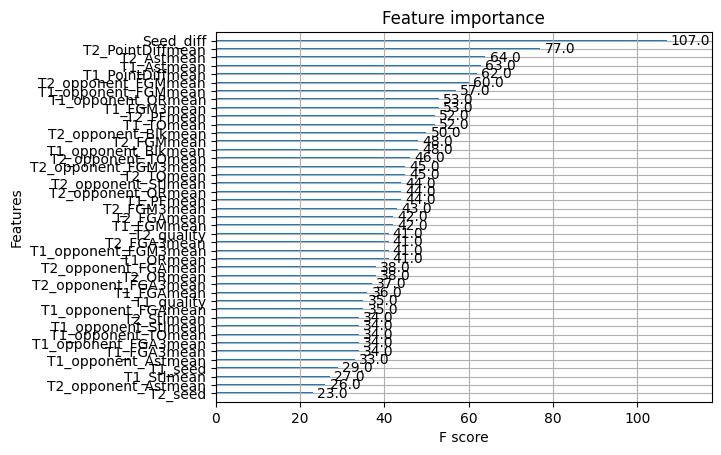

In [29]:
# !pip install xgboost
from xgboost import plot_importance
plot_importance(m1)

#### This is it for the workshop, feel free to improve the model however you see fit. You could look at last year's submission to see how they created a more elaborate model. You can also brainstorm and add more features. Some things that I could think of might be home and away splits, getting player-by-player statistics, or adding in standard error for team statistics.